# CSCI 3202, Spring 2022: Final Coding Project

---


This is your final programming project for CSCI 3202. It is due on Canvas by **11:59 PM on Saturday April 30**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.

You have two options for completing your final project for this course. The first option is presented in this notebook and involves implementing a reinforcement learning algorithm and producing a five-minute video that explains your process of solving this problem. The second option is to design your own project that includes the algorithms we've discussed since the midterm - Bayes Nets, Hidden Markov Models, Markov Decision Processes, or Reinforcement Learning - or an algorithm related to one of these that we haven't discussed in class. Your project also needs to include some kind of analysis of how it performed on a specific problem. If you're interested in the design your own project option, you need to discuss your idea with one of the course instructors to get approval. If you do a project without getting approval, you will receive a 0 regardless of the quality of the project. You will also need to produce a short, five-minute video that explains your project.

**The rules:**

1. Choose EITHER the given problem to submit OR choose your own project topic. 

2. If you choose your own project topic, please adhere to the following guidelines:
- The project needs to be approved by the course instructors.
- The project needs to include one of the algorithms we've discussed since the midterm - Bayes Nets, HMMs, MDPs, or Reinforcement Learning - or an algorithm that we haven't discussed in class. 
- If you do your own project without prior approval, you will receive a 0 for this project.
- Your project code, explanation, and results must all be contained in a Jupyter notebook. 

3. All work, code and analysis must be **your own**.
4. You may use your course notes, posted lecture slides, textbook, in-class notebooks and homework solutions as resources.  You may also search online for answers to general knowledge questions, like the form of a probability distribution function, or how to perform a particular operation in Python. You may not use entire segments of code as solutions to any part of this project, e.g. if you find a Python implementation of policy iteration online, you can't use it.
5. You may **not** post to message boards or other online resources asking for help.
6. **You may not collaborate with classmates or anyone else.**
7. This is meant to be like a coding portion of your final exam. So, we will be much less helpful than we typically am with homework. For example, we will not check answers, help debug your code, and so on.
8. If you have a question, post it first as a **private** Piazza message. If we decide that it is appropriate for the entire class, then we will make it a public post (and anonymous).
9. If something is left open-ended, it is probably because we intend for you to code it up however you want, and only care about the plots/analysis we see at the end. Feel free to ask clarifying questions though.

Violation of these rules will result in an **F** and a trip to the Honor Code council.

---
**By writing your name below, you agree to abide by these rules:**

**Your name:** Kyle Moe

---



In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors



---
## [100 pts] Problem 1:  Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if the drone is at $(x,y,z)$ it means that the box is centered at $(x,y,z)$. There are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. For example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a living reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the landing pad is, and how to get there from any initial state.

Before moving on to Part B, we recommend that you test that your MDPLanding code is set up correctly. Write unit tests that display the actions for a given state, rewards, results, etc. This will help you identify errors in your implementation and save you a lot of debugging time later.

In [2]:
# Your code here.

class MDPLanding:
    def __init__(self, L, default_reward=-0.01, gamma=0.999, success_reward=1,failure_reward=-1):
        self.L = L
        
        self.states = []
        self.terminal_states = {}
        
        for i in range(L+1):
            for j in range(L+1):
                if (i == j) and (i == self.L // 2):
                    self.terminal_states[(i,j,0)] = success_reward
                else:
                    self.terminal_states[(i,j,0)] = failure_reward
                for k in range(L+1):
                    self.states.append((i,j,k))
        
        self.default_reward = default_reward
        #                  ['up',   'down',  'east',  'west', 'north', 'south']
        self.all_actions = [(0,0,1),(0,0,-1),(0,-1,0),(0,1,0),(-1,0,0),(1,0,0)]
        self.gamma = gamma
        
    def actions(self, state):
        if state not in self.states:
            raise ValueError('State provided is not valid')
            
            
        possible_actions = []
        for action in self.all_actions:
            if tuple(map(sum, zip(action, state))) in self.states:
                possible_actions.append(action)
        return possible_actions
    
    def reward(self, state):
        if state not in self.states:
            raise ValueError('State provided is not valid')
            
            
        if state in self.terminal_states:
            return self.terminal_states[state]
        return self.default_reward
        
    def result(self, state, action):
        if state not in self.states:
            raise ValueError('State provided is not valid')
        if action not in self.actions(state):
            raise ValueError('Action cannot be made by state')
            
            
        return self.reward(tuple(map(sum, zip(action, state))))
        

In [3]:
mdp = MDPLanding(2)
print(mdp.actions((0,0,1)))

[(0, 0, 1), (0, 0, -1), (0, 1, 0), (1, 0, 0)]


In [4]:
a = (1,0,0)
b = (0,1,0)
c = (0,0,1)
tuple(map(sum,zip(a,b,c)))

(1, 1, 1)

#### Part B
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case (so 125 total states).

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and **comment on the results**:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

The policy for each of these states is the action that the agent should take in that state. 

In [5]:
# Your code here.

# https://www.baeldung.com/cs/ml-value-iteration-vs-policy-iteration

class PI:
    def __init__(self, mdp, max_iterations=100):
        # initialize value and policy
        V = {}
        policy = {}
        for state in mdp.states:
            #if state not in mdp.terminal_states:
            V[state] = 0
            actions = mdp.actions(state)
            policy[state] = actions[np.random.randint(0,len(actions))]


        iterations = 0
        converged = False
        while not converged and iterations < max_iterations:
            converged = True
            iterations += 1
            
            # policy evaluation
            for state in V:
                if state not in mdp.terminal_states:
                    V[state] = mdp.result(state, policy[state]) + V[tuple(map(sum, zip(policy[state], state)))]* mdp.gamma

            # policy improvement
            for state in V:
                if state not in mdp.terminal_states:
                    old_best = V[state]
                    for action in mdp.actions(state):
                        action_result = mdp.result(state, action) + V[tuple(map(sum, zip(action, state)))] * mdp.gamma
                        if action_result > old_best:
                            policy[state] = action
                            old_best = action_result
                            converged = False
        for state in mdp.terminal_states:
            V.pop(state)
            policy.pop(state)
            
        print("Converged in " + str(iterations) + " iterations")
        self.V = V
        self.policy = policy
        self.mdp = mdp
        
    def policy_iteration(self, start):
        policies = {}
        state = start
        while state not in self.mdp.terminal_states:
            policies[state] = self.policy[state]
            state = tuple(map(sum, zip(self.policy[state], state)))
        return policies

In [6]:
mdp = MDPLanding(2)
pi = PI(mdp)
print("Path and policy from (2,2,1): " + str(pi.policy_iteration((2,2,1))))
print("Path and policy from (0,2,1): " + str(pi.policy_iteration((0,2,1))))
print("Path and policy from (2,0,1): " + str(pi.policy_iteration((2,0,1))))
print("Path and policy from (2,2,2): " + str(pi.policy_iteration((2,2,2))))
mdp4 = MDPLanding(4)
pi4 = PI(mdp4)
print("Path and policy from (4,4,4): " + str(pi4.policy_iteration((4,4,4))))

Converged in 4 iterations
Path and policy from (2,2,1): {(2, 2, 1): (-1, 0, 0), (1, 2, 1): (0, -1, 0), (1, 1, 1): (0, 0, -1)}
Path and policy from (0,2,1): {(0, 2, 1): (1, 0, 0), (1, 2, 1): (0, -1, 0), (1, 1, 1): (0, 0, -1)}
Path and policy from (2,0,1): {(2, 0, 1): (0, 1, 0), (2, 1, 1): (-1, 0, 0), (1, 1, 1): (0, 0, -1)}
Path and policy from (2,2,2): {(2, 2, 2): (0, -1, 0), (2, 1, 2): (-1, 0, 0), (1, 1, 2): (0, 0, -1), (1, 1, 1): (0, 0, -1)}
Converged in 7 iterations
Path and policy from (4,4,4): {(4, 4, 4): (0, -1, 0), (4, 3, 4): (0, -1, 0), (4, 2, 4): (-1, 0, 0), (3, 2, 4): (0, 0, -1), (3, 2, 3): (0, 0, -1), (3, 2, 2): (-1, 0, 0), (2, 2, 2): (0, 0, -1), (2, 2, 1): (0, 0, -1)}


The above results demonstraights the ability of this method to converge to the optimal path in few iterations for a small sample space. The paths found have no issue passing by the terminal states with -1 utility to reach the middle and then the optimal finish. 

#### Part C

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values.  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. We refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets in Part D below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [7]:
# Your code here.

class QLearner:
    def __init__(self, mdp, episodes=50, gamma=0.999, alpha=0.9, epsilon=0.1):
        self.mdp = mdp
        self.episodes = episodes
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.starting_states = []
        self.cumulativeRewards = []
        
        self.Q = {}
        for state in self.mdp.states:
            if state not in self.mdp.terminal_states:
                self.starting_states.append(state)
            self.Q[state] = {}
            for action in self.mdp.actions(state):
                self.Q[state][action] = 0
        
        for episode in range(episodes):
            # get starting state from non-terminal states
            state = self.starting_states[np.random.randint(len(self.starting_states))]
            cumulativeReward = 0
            while state not in self.mdp.terminal_states:
                # implement epsilon-greedy algorithm to select current action with 
                # 1-epsilon probability, random otherwise from non-current action

                # current action is maximum Q
                action = max(self.Q[state], key=self.Q[state].get)
                # explore
                if (np.random.choice([0, 1], p=[1-epsilon, epsilon])):
                    best = -np.Infinity
                    a_best = 0
                    for a in self.Q[state]:
                        if (a != action) and (self.Q[state][a] > best): 
                            a_best = a
                            best = self.Q[state][a]
                    action = a_best
                    
                s_new = tuple(map(sum, zip(action, state)))
                r = mdp.reward(s_new)
                cumulativeReward += r
                
                # Update Q
                bestNewQ = max(self.Q[s_new], key=self.Q[s_new].get)
                self.Q[state][action] += self.alpha * (r + self.gamma * (self.Q[s_new][bestNewQ] - self.Q[state][action]))
                state = s_new
            self.cumulativeRewards.append(cumulativeReward)
        
    def QRewards(self):
        return self.Q, self.cumulativeRewards

In [8]:
q, r = QLearner(mdp).QRewards()
print("q:\n" + str(q))
print("\nr:\n" + str(r))

q:
{(0, 0, 0): {(0, 0, 1): 0, (0, 1, 0): 0, (1, 0, 0): 0}, (0, 0, 1): {(0, 0, 1): -0.009000000000000001, (0, 0, -1): -0.9, (0, 1, 0): -0.009000000000000001, (1, 0, 0): 0.9778723750692464}, (0, 0, 2): {(0, 0, -1): 0.8532108985465542, (0, 1, 0): 0.8710894937734583, (1, 0, 0): -0.018000000000000002}, (0, 1, 0): {(0, 0, 1): 0, (0, -1, 0): 0, (0, 1, 0): 0, (1, 0, 0): 0}, (0, 1, 1): {(0, 0, 1): -0.009000000000000001, (0, 0, -1): -0.9, (0, -1, 0): -0.009000000000000001, (0, 1, 0): -0.009000000000000001, (1, 0, 0): 0.9908882758725389}, (0, 1, 2): {(0, 0, -1): -0.009908100000000001, (0, -1, 0): -0.018000000000000002, (0, 1, 0): -0.0170919, (1, 0, 0): 0.9809703976216692}, (0, 2, 0): {(0, 0, 1): 0, (0, -1, 0): 0, (1, 0, 0): 0}, (0, 2, 1): {(0, 0, 1): -0.018898854806439002, (0, 0, -1): -0.9, (0, -1, 0): 0.9772182067388219, (1, 0, 0): 0.9809707109682151}, (0, 2, 2): {(0, 0, -1): 0.9688733648189618, (0, -1, 0): -0.018000000000000002, (1, 0, 0): -0.018000000000000002}, (1, 0, 0): {(0, 0, 1): 0, (0, 1

#### Part D

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your code.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

In [9]:
# Your code here.

mdp10 = MDPLanding(10)
q, r = QLearner(mdp10, episodes=10000).QRewards()
print("Mean of last 5000 episodes: " + str(np.sum(r[5000:])/len(r[5000:])))

Mean of last 5000 episodes: 0.8727440000000001


Text(0, 0.5, 'Average Cumulative Reward')

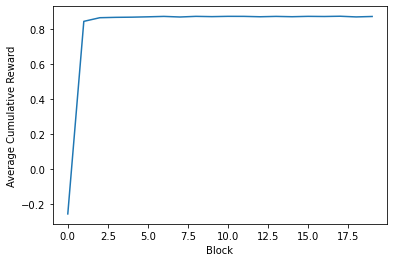

In [10]:
blockMeanRewards = []
for i in range(len(r) // 500):
    blockMeanRewards.append(np.sum(r[i*500:(i+1)*500]) / len(r[i*500:(i+1)*500]))
    
plt.plot(np.arange(len(blockMeanRewards)), blockMeanRewards)
plt.xlabel("Block")
plt.ylabel("Average Cumulative Reward")

#### Part E

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training?

The cumulative average reward begins around -0.5 for the first block of training because of the size of the sample space. We are contending with a 10x10x10 grid meaning 1000 possible states. While only 1/9 of these are starting states, many will still be unexplored after the end of training. Based on the way Q accumulates from previous iterations, we will still be directed to the terminal states for a lot of states where we have too few iterations to have sufficiently explored. However, we will still reach the +1 terminal state often as well as we begin in previously explored states or transition to them throughout an episode.

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8?

It is difficult to reliably get rewards all that much greater than the limit we can see in the above plot because of the default rewards for passive states. Depending on the starting state, we will have no choice to accumulate at least some of these default rewards at each states. The reduciton from 1 to \~0.8 is a consequence of the average path the drone has to follow.

#### Part F
Choose three other reward structures, including the terminal rewards and the living rewards, and rerun your policy iteration and Q-learning algorithms with those reward structures. Write a paragraph or two describing the reward structures that you selected, what impact you expected the changes to have on your results, and what changes actually happened. If there was a difference in what you expected and what actually happened, reflect on why there was a difference. 

Mean of last 5000 episodes: 8.6829


Text(0, 0.5, 'Average Cumulative Reward')

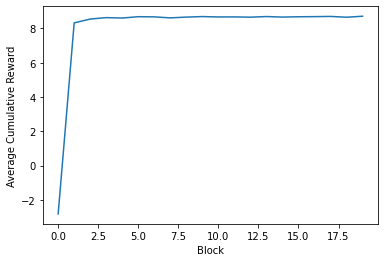

In [12]:
# Scale success reward, failure reward, and default reward by 10.

mdp10 = MDPLanding(10, success_reward=10,failure_reward=-10, default_reward=-0.1)
q, r = QLearner(mdp10, episodes=10000).QRewards()
print("Mean of last 5000 episodes: " + str(np.sum(r[5000:])/len(r[5000:])))

blockMeanRewards = []
for i in range(len(r) // 500):
    blockMeanRewards.append(np.sum(r[i*500:(i+1)*500]) / len(r[i*500:(i+1)*500]))
    
plt.plot(np.arange(len(blockMeanRewards)), blockMeanRewards)
plt.xlabel("Block")
plt.ylabel("Average Cumulative Reward")

What I expected the above cell to show is that scaling all of the rewards by the same factor should not do anything to change the actual performance except that the cumulative rewards should too be scaled by 10. The algorithm is effectively operating identically as before and may as well have this factor added in after the fact. 

Mean of last 5000 episodes: 9.869628


Text(0, 0.5, 'Average Cumulative Reward')

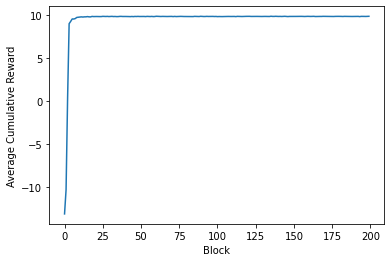

In [14]:
# Scale success reward and failure reward but leave default reward unchanged

mdp10 = MDPLanding(10, success_reward=10,failure_reward=-10, default_reward=-0.01)
q, r = QLearner(mdp10, episodes=10000).QRewards()
print("Mean of last 5000 episodes: " + str(np.sum(r[5000:])/len(r[5000:])))

blockMeanRewards = []
for i in range(len(r) // 500):
    blockMeanRewards.append(np.sum(r[i*500:(i+1)*500]) / len(r[i*500:(i+1)*500]))
    
plt.plot(np.arange(len(blockMeanRewards)), blockMeanRewards)
plt.xlabel("Block")
plt.ylabel("Average Cumulative Reward")

Admittedly, the above result caught me off guard. I did not really expect there to be such a drastic increase in the cumulative rewards nor did I think the algorithm would so quickly move past finding mostly negative rewards. What seems to be happening is that the agent feels far more at liberty to explore rather than committing to ending up at a negative terminal state. This is because the loss for each step of exploration and increase in the path length does little to reduce the total reward on account of the accumulated default penalty. Thus, very rapidly, the optimal move at each state tends to get revealed within the large amount of episodes. 

Mean of last 5000 episodes: -0.27406000000000014


Text(0, 0.5, 'Average Cumulative Reward')

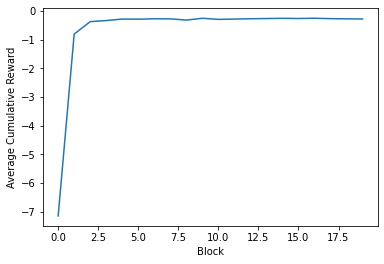

In [15]:
# increase only the default reward

mdp10 = MDPLanding(10, success_reward=1,failure_reward=-1, default_reward=-0.1)
q, r = QLearner(mdp10, episodes=10000).QRewards()
print("Mean of last 5000 episodes: " + str(np.sum(r[5000:])/len(r[5000:])))

blockMeanRewards = []
for i in range(len(r) // 500):
    blockMeanRewards.append(np.sum(r[i*500:(i+1)*500]) / len(r[i*500:(i+1)*500]))
    
plt.plot(np.arange(len(blockMeanRewards)), blockMeanRewards)
plt.xlabel("Block")
plt.ylabel("Average Cumulative Reward")

The above cell is interesting and shows roughly what I expected considering the size of the sample space. By making the default reward -0.1, there is substantial penalty for traversing any state where there is not a positive terminal reward. In a 10x10x10 cube, There are many states (300 ish out of 1000) for which the optimal path requires traversing at least 10 of these regardless so the cumulative reward must, by construction, be negative. It seems that even with the states for which the path is short enough that there is a positive reward, the average is still negative.